In [1]:
%matplotlib inline

In [2]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 1
    eval_batch_size = 1  # how many images to sample during evaluation
    num_epochs = 2
    gradient_accumulation_steps = 1
    learning_rate = 5e-5
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

    num_train_timesteps=300
    num_inference_timesteps=300


config = TrainingConfig()

In [3]:
from datasets import load_dataset
import torch
from torchvision import transforms

# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split="train[:2]")

# preprocess = transforms.Compose(
#     [
#         transforms.Resize((config.image_size, config.image_size)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5]),
#     ]
# )

# def transform(examples):
#     images = [preprocess(image.convert("RGB")) for image in examples["image"]]
#     return {"images": images}


config.dataset_name = "fashion_mnist"
dataset = load_dataset("fashion_mnist", split="train[:1]")

preprocess = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((config.image_size,config.image_size)),
        transforms.ToTensor(),
        # transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)


def transform(examples):
    images = [
        preprocess(image.convert("L")) for image in examples["image"]
    ]
    return {"images": images}

Found cached dataset fashion_mnist (/media/master/wext/cv_data/hf_home/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


/tmp/ipykernel_217171/1860928979.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


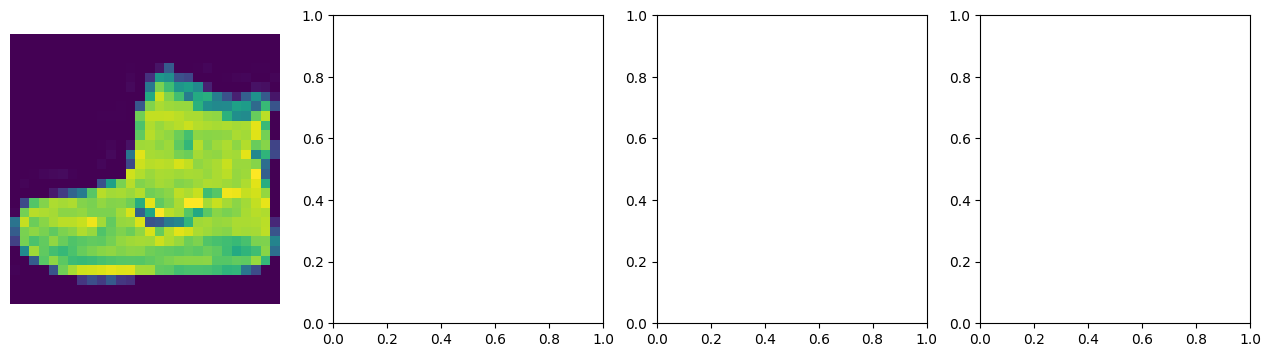

In [4]:

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

dataset.set_transform(transform)

In [5]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [6]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

113668609

In [113]:
import gc; gc.collect()
torch.cuda.empty_cache()

In [114]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 64, 64])
Output shape: torch.Size([1, 1, 64, 64])


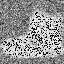

In [115]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0][:,:,-1], 'L')

In [116]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [117]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
# lr_scheduler = get_cosine_schedule_with_warmup(
#     optimizer=optimizer,
#     num_warmup_steps=config.lr_warmup_steps,
#     num_training_steps=(len(train_dataloader) * config.num_epochs),
# )
lr_scheduler=None

In [118]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        num_inference_steps=config.num_inference_timesteps,
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [119]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=True or not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            
            # if step == 1: break

            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                # lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": optimizer.optimizer.param_groups[0]['lr'], "step": global_step}
            # logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler,
            )

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f'Epoch: {epoch}\t{logs}')
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [126]:
dataset[0]['images'].shape

torch.Size([1, 64, 64])

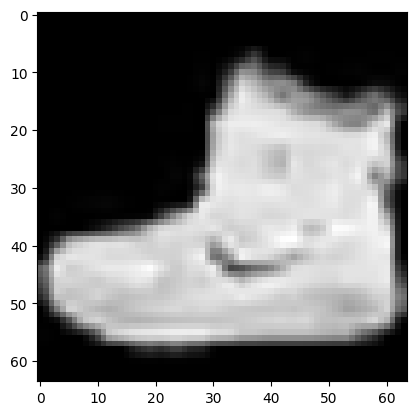

: 

In [129]:
plt.imshow(dataset[0]['images'].permute(1,2,0).cpu().numpy(), cmap='gray')

In [120]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

# notebook_launcher(train_loop, args, num_processes=1)
config.num_epochs = 2000
config.save_image_epochs=200
config.eval_batch_size = 2
train_loop(*args)

Epoch: 199	{'loss': 0.008948441594839096, 'lr': 5e-05, 'step': 199}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 399	{'loss': 0.005257408134639263, 'lr': 5e-05, 'step': 399}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 599	{'loss': 0.004241717513650656, 'lr': 5e-05, 'step': 599}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 799	{'loss': 0.002502641174942255, 'lr': 5e-05, 'step': 799}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 999	{'loss': 0.002500801347196102, 'lr': 5e-05, 'step': 999}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1199	{'loss': 0.002729601925238967, 'lr': 5e-05, 'step': 1199}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1399	{'loss': 0.0011293962597846985, 'lr': 5e-05, 'step': 1399}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1599	{'loss': 0.0008829780272208154, 'lr': 5e-05, 'step': 1599}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1799	{'loss': 0.0010111003648489714, 'lr': 5e-05, 'step': 1799}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1999	{'loss': 0.0008030252647586167, 'lr': 5e-05, 'step': 1999}


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
config.save_image_epochs=100
config.eval_batch_size = 2
train_loop(*args)

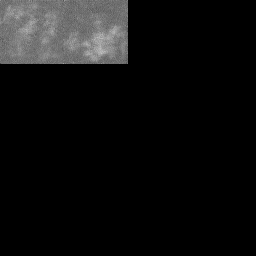

In [50]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])